# A Journey into sound

In [1]:
from IPython.display import Audio, display
display(Audio(filename="../ESC-50/train/1-100032-A-0.wav"))

In [57]:
import librosa, torchvision, time, glob
import matplotlib.pyplot as plt
from pathlib import Path 
import numpy as np
from PIL import Image
from torch.utils.data import Dataset 
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim 

device = "cuda" if torch.cuda.is_available() else "cpu" 


In [2]:
# last char in file name is the class
from collections import Counter 
esc50_list = [f.split("-")[-1].replace(".wav", "")
              for f in glob.glob("../ESC-50/audio/*.wav")]
Counter(esc50_list)

Counter()

In [3]:
import torchaudio
import warnings
warnings.filterwarnings(
    "ignore",
    message=r"In 2\.9, this function's implementation will be changed to use torchaudio\.load_with_torchcodec",
    category=UserWarning,
)


class ESC50(Dataset):
    def __init__(self, path):
        files = Path(path).glob("*.wav")
        # items: list of (filename, class)
        self.items = [(f, int(f.name.split("-")[-1].replace(".wav",""))) 
                      for f in files]
        self.length = len(self.items)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, sample_rate = torchaudio.load(filename)
        return audio_tensor, label # audio_tensor: [1,time]
        

In [4]:
test_esc50 = ESC50("../ESC-50/train")
tensor, label = list(test_esc50)[0]
print(tensor)
print(tensor.shape)
print(label)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([1, 220500])
0


In [5]:
example_loader = torch.utils.data.DataLoader(test_esc50, batch_size=64, shuffle=True)

In [6]:
bs = 64 
device = "cuda" if torch.cuda.is_available() else "cpu" 

PATH_TO_ESC50 = Path.cwd() / ".." / "ESC-50"
train_esc50 = ESC50(PATH_TO_ESC50 / "train")
valid_esc50 = ESC50(PATH_TO_ESC50 / "valid")
test_esc50 = ESC50(PATH_TO_ESC50 / "test")

train_loader = torch.utils.data.DataLoader(train_esc50, batch_size=bs, shuffle=True, num_workers=0, pin_memory=(device=="cuda"))
valid_loader = torch.utils.data.DataLoader(valid_esc50, batch_size=bs, shuffle=False, num_workers=0, pin_memory=(device=="cuda"))
test_loader = torch.utils.data.DataLoader(test_esc50, batch_size=bs, shuffle=False, num_workers=0, pin_memory=(device=="cuda"))

In [7]:
import torch.nn.functional as F

class AudioNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # (in_channels, out_channels, kernel, stride)
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4) # kernel_size=4

        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)

        self.conv3 = nn.Conv1d(128, 256, 3) # conv3: (batch,256,time) 
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(256, 512, 3)# conv4: (batch,512,time)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)

        self.avgPool = nn.AdaptiveAvgPool1d(1) # (batch,512,time)
        self.fc1 = nn.Linear(512,num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)

        x = self.avgPool(x).squeeze(-1) # (batch,512)
        logits = self.fc1(x) # (batch,classes)
        return logits

def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-7, final_value=10, device="cpu"):
    model.train()
    num_batches = len(train_loader)-1
    if num_batches <= 0:
        raise ValueError("Need at least 2 batches for LR finder.")
    mult = (final_value / init_value) ** (1/num_batches)
    lr = init_value 
    for pg in optimizer.param_groups:
        pg["lr"] = lr
    best_loss = float("inf")
    batch_idx = 0
    lrs, losses = [], []
    for inputs, targets in train_loader:
        batch_idx += 1
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).long()
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss_val = float(loss.item())
        lrs.append(lr)
        losses.append(loss_val)
        if loss_val<best_loss:
            best_loss = loss_val
        # stop if exploding
        if batch_idx > 1 and loss_val > best_loss * 4:
            break

        loss.backward()
        optimizer.step() 
        
        # KEY: changing learning-rate here
        lr *= mult 
        for pg in optimizer.param_groups:
            pg["lr"]= lr
            
        if lr > final_value or batch_idx >= len(train_loader):
            break 
    # trim a bit from both ends for nicer plot
    if len(lrs) > 20:
        return lrs[10:-5], losses[10:-5]
    return lrs, losses
        


In [8]:
@torch.no_grad()
def evaluate(model, loss_fn, loader, device):
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0 
    for inputs, targets in loader:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).long()
        logits = model(inputs)
        loss = loss_fn(logits, targets)
        total_loss += float(loss.item()) * inputs.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds==targets).sum().item()
        total_count += inputs.size(0)
    return total_loss / max(1, total_count), total_correct / max(1, total_count)



In [9]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
    for epoch in range(1, epochs+1):
        model.train()
        run_loss = 0.0
        seen = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True).long()
            optimizer.zero_grad(set_to_none=True)
            logits = model(inputs)
            loss = loss_fn(logits, targets)
            loss.backward()
            optimizer.step()
            run_loss += float(loss.item()) * inputs.size(0)
            seen += inputs.size(0)
        train_loss = run_loss / max(1,seen)
        val_loss, val_acc = evaluate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | val_acc {val_acc:.4f}")

### LR Finder

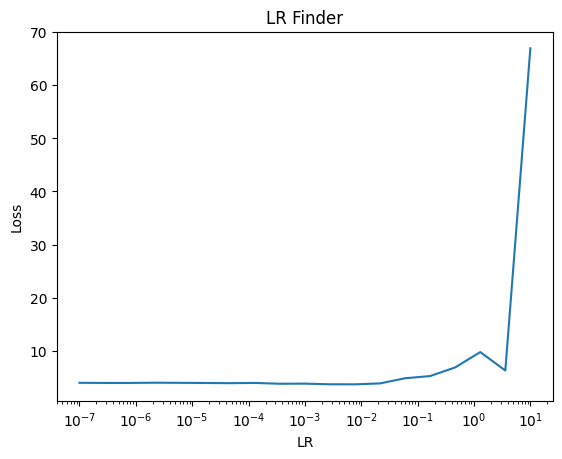

In [10]:
import matplotlib.pyplot as plt

audio_net = AudioNet(num_classes=50).to(device)
criterion = nn.CrossEntropyLoss()
lr_opt = optim.Adam(audio_net.parameters(), lr=1e-7, weight_decay=1e-4)
lrs, losses = find_lr(audio_net, criterion, lr_opt, train_loader, device=device)

plt.figure()
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("LR")
plt.ylabel("Loss")
plt.title("LR Finder")
plt.show()

### Train

In [11]:
EPOCHS = 30
optimizer = optim.Adam(audio_net.parameters(), lr=1e-5)
train(audio_net, optimizer, criterion, train_loader, valid_loader, EPOCHS, device)

Epoch 001 | train_loss 78.3644 | val_loss 112.2036 | val_acc 0.0150
Epoch 002 | train_loss 77.9673 | val_loss 62.4241 | val_acc 0.0150
Epoch 003 | train_loss 76.8645 | val_loss 68.8177 | val_acc 0.0150
Epoch 004 | train_loss 79.8242 | val_loss 62.9956 | val_acc 0.0125
Epoch 005 | train_loss 77.0018 | val_loss 64.3288 | val_acc 0.0150
Epoch 006 | train_loss 76.9408 | val_loss 64.0261 | val_acc 0.0150
Epoch 007 | train_loss 78.5664 | val_loss 64.6491 | val_acc 0.0125
Epoch 008 | train_loss 76.0191 | val_loss 59.2437 | val_acc 0.0150
Epoch 009 | train_loss 77.0385 | val_loss 60.2633 | val_acc 0.0150
Epoch 010 | train_loss 75.3718 | val_loss 63.1726 | val_acc 0.0150
Epoch 011 | train_loss 76.5196 | val_loss 65.9950 | val_acc 0.0150
Epoch 012 | train_loss 75.5313 | val_loss 61.0077 | val_acc 0.0125
Epoch 013 | train_loss 78.4623 | val_loss 60.5782 | val_acc 0.0125
Epoch 014 | train_loss 75.9991 | val_loss 60.4227 | val_acc 0.0125
Epoch 015 | train_loss 75.6688 | val_loss 61.0790 | val_acc 0

In [12]:
test_loss, test_acc = evaluate(audio_net, criterion, test_loader, device)
print(f"Test | loss {test_loss:.4f} | acc {test_acc:.4f}")
torch.save(audio_net.state_dict(), "audionet.pth")

Test | loss 91.0709 | acc 0.0175


## Mel Spectrogram

In [13]:
import numpy as np

sample_data, sr = librosa.load("../ESC-50/train/1-100032-A-0.wav", sr=None)

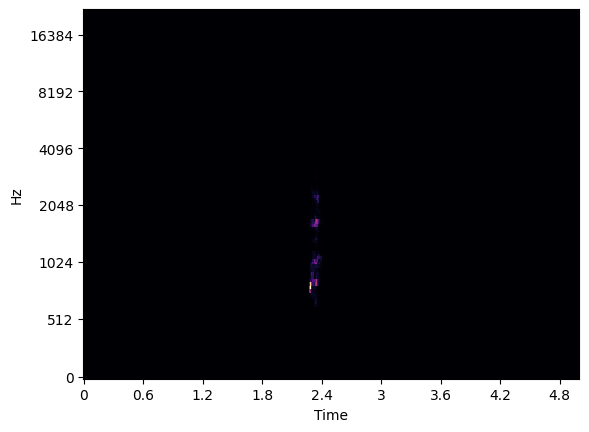

In [14]:
spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')

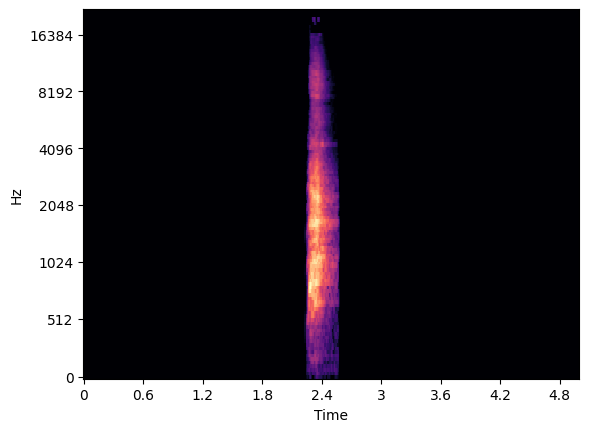

In [15]:
# compute a scaling factor = 10*log10(spectrogram/ref)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(log_spectrogram, sr=sr, x_axis="time", y_axis="mel")

In [16]:
log_spectrogram.shape


(128, 431)

In [20]:
import functools

class ESC50Spectrogram(Dataset):
    def __init__(self, path):
        files = Path(path).glob("*.wav")
        # list of ('test.wav', 4), ...
        self.items = [(f, int(f.name.split("-")[-1].replace(".wav", "")))
            for f in files]
        self.length = len(self.items)
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()])

    # set Least Recently Used (LRU) cache
    @functools.lru_cache(maxsize=None)
    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, sample_rate = librosa.load(filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(y=audio_tensor, sr=sample_rate)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        fig = plt.figure(figsize=(3,3))
        librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
        fig.canvas.draw()
        audio_data = np.asarray(fig.canvas.buffer_rgba())[:,:,:3]
        audio_data = audio_data.reshape(fig.canvas.get_width_height()[::-1] + (3,)) # (width,height)=>(height,width)=>(height,width,3)
        plt.close(fig)
        return (self.transforms(audio_data), label)
        
    def __len__(self):
        return self.length

In [21]:
oldESC50 = ESC50("../ESC-50/train/")
start_time = time.process_time()
oldESC50.__getitem__(33)
end_time = time.process_time()
old_time = end_time - start_time 
old_time


0.0

In [22]:
newESC50 = ESC50Spectrogram("../ESC-50/train/")
start_time = time.process_time()
newESC50.__getitem__(33)
end_time = time.process_time()
new_time = end_time - start_time
new_time

0.28125

In [3]:
def precompute_spectrograms(path, dpi=50):
    files = Path(path).glob("*.wav")
    outdir = Path(path) / "spectrograms"
    outdir.mkdir(parents=True, exist_ok=True)
    
    for filename in files:
        path_saved = outdir / f"{filename.stem}_{dpi}.png"
        # Skip if file already exists
        if path_saved.exists():
            print("Skip:", path_saved)
            continue
            
        audio_tensor, sample_rate = librosa.load(filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(y=audio_tensor, sr=sample_rate)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis="time", y_axis="mel")
        
        plt.savefig(path_saved, dpi=dpi)
        print("Saved:", path_saved)


In [7]:
precompute_spectrograms("../ESC-50/train")


Skip: ../ESC-50/train/spectrograms/2-146877-A-31_50.png
Skip: ../ESC-50/train/spectrograms/2-80844-A-13_50.png
Skip: ../ESC-50/train/spectrograms/1-75190-A-8_50.png
Skip: ../ESC-50/train/spectrograms/2-108760-B-14_50.png
Skip: ../ESC-50/train/spectrograms/2-85292-A-24_50.png
Skip: ../ESC-50/train/spectrograms/3-157695-A-0_50.png
Skip: ../ESC-50/train/spectrograms/3-117793-A-37_50.png
Skip: ../ESC-50/train/spectrograms/3-132830-A-32_50.png
Skip: ../ESC-50/train/spectrograms/3-68630-C-40_50.png
Skip: ../ESC-50/train/spectrograms/1-27166-A-35_50.png
Skip: ../ESC-50/train/spectrograms/3-253081-A-2_50.png
Skip: ../ESC-50/train/spectrograms/3-142604-A-24_50.png
Skip: ../ESC-50/train/spectrograms/3-95695-A-5_50.png
Skip: ../ESC-50/train/spectrograms/3-119120-E-48_50.png
Skip: ../ESC-50/train/spectrograms/3-203375-A-39_50.png
Skip: ../ESC-50/train/spectrograms/1-79236-A-36_50.png
Skip: ../ESC-50/train/spectrograms/2-120218-A-30_50.png
Skip: ../ESC-50/train/spectrograms/3-148932-A-34_50.png
Ski

In [8]:
precompute_spectrograms("../ESC-50/valid")


Skip: ../ESC-50/valid/spectrograms/4-255371-A-47_50.png
Skip: ../ESC-50/valid/spectrograms/4-99644-C-4_50.png
Skip: ../ESC-50/valid/spectrograms/4-191687-A-0_50.png
Skip: ../ESC-50/valid/spectrograms/4-133047-C-5_50.png
Skip: ../ESC-50/valid/spectrograms/4-182795-A-14_50.png
Skip: ../ESC-50/valid/spectrograms/4-161099-A-47_50.png
Skip: ../ESC-50/valid/spectrograms/4-155650-A-24_50.png
Skip: ../ESC-50/valid/spectrograms/4-157611-B-41_50.png
Skip: ../ESC-50/valid/spectrograms/4-209536-A-37_50.png
Skip: ../ESC-50/valid/spectrograms/4-149294-A-41_50.png
Skip: ../ESC-50/valid/spectrograms/4-135439-A-18_50.png
Skip: ../ESC-50/valid/spectrograms/4-201988-A-44_50.png
Skip: ../ESC-50/valid/spectrograms/4-181955-B-3_50.png
Skip: ../ESC-50/valid/spectrograms/4-194754-A-0_50.png
Skip: ../ESC-50/valid/spectrograms/4-212698-A-39_50.png
Skip: ../ESC-50/valid/spectrograms/4-202298-A-31_50.png
Skip: ../ESC-50/valid/spectrograms/4-183487-A-1_50.png
Skip: ../ESC-50/valid/spectrograms/4-108352-A-33_50.png

In [9]:
precompute_spectrograms("../ESC-50/test")


Skip: ../ESC-50/test/spectrograms/5-215658-A-12_50.png
Skip: ../ESC-50/test/spectrograms/5-194899-D-3_50.png
Skip: ../ESC-50/test/spectrograms/5-179860-A-43_50.png
Skip: ../ESC-50/test/spectrograms/5-216214-A-13_50.png
Skip: ../ESC-50/test/spectrograms/5-160614-F-48_50.png
Skip: ../ESC-50/test/spectrograms/5-207836-A-29_50.png
Skip: ../ESC-50/test/spectrograms/5-211197-A-24_50.png
Skip: ../ESC-50/test/spectrograms/5-198411-G-20_50.png
Skip: ../ESC-50/test/spectrograms/5-212054-A-36_50.png
Skip: ../ESC-50/test/spectrograms/5-213293-A-23_50.png
Skip: ../ESC-50/test/spectrograms/5-213855-A-0_50.png
Skip: ../ESC-50/test/spectrograms/5-257642-A-39_50.png
Skip: ../ESC-50/test/spectrograms/5-209989-A-22_50.png
Skip: ../ESC-50/test/spectrograms/5-263775-B-26_50.png
Skip: ../ESC-50/test/spectrograms/5-238926-A-31_50.png
Skip: ../ESC-50/test/spectrograms/5-238938-A-27_50.png
Skip: ../ESC-50/test/spectrograms/5-181458-A-33_50.png
Skip: ../ESC-50/test/spectrograms/5-254832-B-15_50.png
Skip: ../ESC

In [67]:
class PrecomputedESC50(Dataset):
    def __init__(self, path, dpi=50, transforms=None):
        files = Path(path).glob(f"*{dpi}*.png")
        self.items = [(f, int(f.name.split("-")[-1].split("_")[0]))
                      for f in files]
        self.length = len(self.items)
        if transforms==None:
            self.transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        else:
            self.transforms = transforms
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert("RGB")
        return self.transforms(img), label
        
precomputed = PrecomputedESC50("../ESC-50/train/spectrograms")

In [68]:
start_time = time.process_time()
precomputed.__getitem__(33)
end_time = time.process_time()
end_time - start_time


0.027828964999571326

## ResNet for spectrogram

In [83]:
spec_resnet = models.resnet50(pretrained=True)
for param in spec_resnet.parameters():
    param.requires_grad = False 
spec_resnet.fc = nn.Sequential(
    nn.Linear(spec_resnet.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,50))
spec_resnet.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [84]:
# Notice: ToTensor() outputs (4,H,W) Tensor
esc50pre_train = PrecomputedESC50(
    "../ESC-50/train/spectrograms",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ]))
esc50pre_valid = PrecomputedESC50(
    "../ESC-50/valid/spectrograms",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ]))
bs = 64
esc50_train_loader = torch.utils.data.DataLoader(esc50pre_train, bs, shuffle=True)
esc50_valid_loader = torch.utils.data.DataLoader(esc50pre_valid, bs, shuffle=True)


### Finding a learning rate

In [85]:
def find_lr(model, loss_fn, optimizer, train_loader, device, init_value=1e-8, final_value=10.0):
    batches_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1/batches_in_epoch)
    lr = init_value
    # set which learning-rate being used at what time
    optimizer.param_groups[0]["lr"] = lr
    best_loss = np.inf
    batch_num = 0
    
    lrs = []
    losses = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data 
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss_val = loss.item()

        # Crash out if loss explodes
        if batch_num > 1 and loss>40*best_loss:
            if len(lrs) > 20:
                return lrs[10:-5], losses[10:-5]
            else:
                return lrs, losses
        
        if loss_val < best_loss or batch_num==1:
            best_loss = loss

        losses.append(loss_val)
        lrs.append(lr)
        
        loss.backward()
        optimizer.step()
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
        
    if len(lrs) > 20:
        return lrs[10:-5], losses[10:-5]
    else:
        return lrs, losses
    

In [87]:
torch.save(spec_resnet.state_dict(), "spec_resnet.pth")
loss_fn = nn.CrossEntropyLoss()
lr = 1e-5
optimizer = optim.Adam(spec_resnet.parameters(), lr=lr)
lrs, losses = find_lr(spec_resnet, loss_fn, optimizer, esc50_train_loader, device=device)

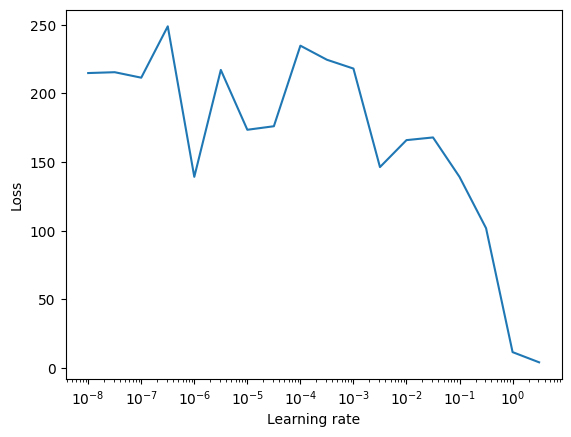

In [89]:
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [91]:
# Freeze the feature-extractor, train ONLY the classifier for 5 epochs with big lr
optimizer = optim.Adam(spec_resnet.parameters(), lr=1e-2)
train(spec_resnet, optimizer, nn.CrossEntropyLoss(), esc50_train_loader, esc50_val_loader, epochs=5, device=device)

NameError: name 'train' is not defined

In [ ]:
# Unfreeze everything and train for 20 epochs with small lr
for param in spec_resnet.parameters():
    param.requires_grad = True
optimizer = optim.Adam(spec_resnet.parameters(), lr=1e-8)
train(spec_resnet, optimizer, nn.CrossEntropyLoss(), esc50_train_loader, esc50_val_loader, epochs=20, device=device)